The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==0.17.1


# Gated Recurrent Units (GRU)
:label:`sec_gru`

Em :numref:`sec_bptt`,
discutimos como os gradientes são calculados
em RNNs.
Em particular, descobrimos que produtos longos de matrizes podem levar
para gradientes desaparecendo ou explodindo.
Vamos pensar brevemente sobre como
anomalias de gradiente significam na prática:

* Podemos encontrar uma situação em que uma observação precoce é altamente
  significativo para prever todas as observações futuras. Considere o
  caso inventado em que a primeira observação contém uma soma de verificação e o objetivo é
  para discernir se a soma de verificação está correta no final da sequência. Nesse
  caso, a influência do primeiro token é vital. Gostaríamos de ter algum
  mecanismos para armazenar informações precoces vitais em uma *célula de memória*. Sem tal
  um mecanismo, teremos que atribuir um gradiente muito grande a esta observação,
  uma vez que afeta todas as observações subsequentes.
* Podemos encontrar situações em que alguns tokens não carreguem
  observação. Por exemplo, ao analisar uma página da web, pode haver
  Código HTML que é irrelevante para o propósito de avaliar o sentimento
  transmitido na página. Gostaríamos de ter algum mecanismo para *pular* tais
  tokens na representação do estado latente.
* Podemos encontrar situações em que haja uma quebra lógica entre as partes de
  uma sequência. Por exemplo, pode haver uma transição entre capítulos em um
  livro, ou uma transição entre um mercado de valores em baixa e em alta. Neste caso seria bom ter um meio de *redefinir* nosso estado interno
  representação.

Vários métodos foram propostos para resolver isso. Uma das mais antigas é a memória de curto prazo longa :cite:`Hochreiter.Schmidhuber.1997` que nós
iremos discutir em :numref:`sec_lstm`. A unidade recorrente fechada (GRU)
:cite:`Cho.Van-Merrienboer.Bahdanau.ea.2014` é uma variante um pouco mais simplificada
que muitas vezes oferece desempenho comparável e é significativamente mais rápido para
computar :cite:`Chung.Gulcehre.Cho.ea.2014`.
Por sua simplicidade, comecemos com o GRU.

## Estado Oculto Fechado

A principal distinção entre RNNs vanilla e GRUs
é que o último suporta o bloqueio do estado oculto.
Isso significa que temos mecanismos dedicados para
quando um estado oculto deve ser *atualizado* e
também quando deve ser *redefinido*.
Esses mecanismos são aprendidos e atendem às questões listadas acima.
Por exemplo, se o primeiro token é de grande importância
aprenderemos a não atualizar o estado oculto após a primeira observação.
Da mesma forma, aprenderemos a pular observações temporárias irrelevantes.
Por último, aprenderemos a redefinir o estado latente sempre que necessário.
Discutimos isso em detalhes abaixo.

### Porta de Reinicialização e a Porta de Atualização

A primeira coisa que precisamos apresentar é
a *porta de reinicialização* e a *porta de atualização*.
Nós os projetamos para serem vetores com entradas em $(0, 1)$
para que possamos realizar combinações convexas.
Por exemplo,
uma porta de reinicialização nos permitiria controlar quanto do estado anterior ainda podemos querer lembrar.
Da mesma forma, uma porta de atualização nos permitiria controlar quanto do novo estado é apenas uma cópia do antigo estado.

Começamos projetando esses portões.
:numref:`fig_gru_1` ilustra as entradas para ambos
as portas de reset e atualização em uma GRU, dada a entrada
da etapa de tempo atual
e o estado oculto da etapa de tempo anterior.
As saídas de duas portas
são fornecidos por duas camadas totalmente conectadas
com uma função de ativação sigmóide.

![Calculando a porta de reinicialização e a porta de atualização em um modelo GRU.](../img/gru-1.svg)
:label:`fig_gru_1`

Matematicamente,
para um determinado intervalo de tempo $ t $,
suponha que a entrada seja
um minibatch
$\mathbf{X}_t \in \mathbb{R}^{n \times d}$ (número de exemplos: $ n $, número de entradas: $ d $) e o estado oculto da etapa de tempo anterior é $\mathbf{H}_{t-1} \in \mathbb{R}^{n \times h}$ (número de unidades ocultas: $ h $). Então, reinicie o portão $\mathbf{R}_t \in \mathbb{R}^{n \times h}$ e atualize o portão $\mathbf{Z}_t \in \mathbb{R}^{n \times h}$ são calculados da seguinte forma:

$$
\begin{aligned}
\mathbf{R}_t = \sigma(\mathbf{X}_t \mathbf{W}_{xr} + \mathbf{H}_{t-1} \mathbf{W}_{hr} + \mathbf{b}_r),\\
\mathbf{Z}_t = \sigma(\mathbf{X}_t \mathbf{W}_{xz} + \mathbf{H}_{t-1} \mathbf{W}_{hz} + \mathbf{b}_z),
\end{aligned}
$$

onde $\mathbf{W}_{xr}, \mathbf{W}_{xz} \in \mathbb{R}^{d \times h}$ e
$\mathbf{W}_{hr}, \mathbf{W}_{hz} \in \mathbb{R}^{h \times h}$ são pesos de parâmetros e $\mathbf{b}_r, \mathbf{b}_z \in \mathbb{R}^{1 \times h}$ são viéses.
Observe que a transmissão (consulte :numref:`subsec_broadcasting`) é acionada durante a soma.
Usamos funções sigmóides (como introduzidas em :numref:`sec_mlp`) para transformar os valores de entrada no intervalo $(0, 1)$.

### Estado Oculto do Candidato

Em seguida, vamos
integrar a porta de reset $\mathbf {R} _t$ com
o mecanismo regular de atualização de estado latente
in :eqref:`rnn_h_with_state`.
Isso leva ao seguinte
*estado oculto candidato*
$\tilde{\mathbf{H}}_t \in \mathbb{R}^{n \times h}$ no passo de tempo $t$:

$$\tilde{\mathbf{H}}_t = \tanh(\mathbf{X}_t \mathbf{W}_{xh} + \left(\mathbf{R}_t \odot \mathbf{H}_{t-1}\right) \mathbf{W}_{hh} + \mathbf{b}_h),$$
:eqlabel:`gru_tilde_H`

onde $\mathbf{W}_{xh} \in \mathbb{R}^{d \times h}$ and $\mathbf{W}_{hh} \in \mathbb{R}^{h \times h}$
são parâmetros de pesos,
$\mathbf{b}_h \in \mathbb{R}^{1 \times h}$
é o viés,
e o símbolo $\odot$ é o operador de produto Hadamard (elemento a elemento).
Aqui, usamos uma não linearidade na forma de tanh para garantir que os valores no estado oculto candidato permaneçam no intervalo $(-1, 1)$.

O resultado é um *candidato*, pois ainda precisamos incorporar a ação da porta de atualização.
Comparando com :eqref:`rnn_h_with_state`,
agora a influência dos estados anteriores
pode ser reduzido com o
multiplicação elementar de
$\mathbf{R}_t$ e$\mathbf{H}_{t-1}$
em :eqref:`gru_tilde_H`.
Sempre que as entradas na porta de reset $\mathbf{R}_t$ estão perto de 1, recuperamos um RNN vanilla como em :eqref:`rnn_h_with_state`.
Para todas as entradas da porta de reset $\mathbf{R}_t$ que estão próximas de 0, o estado oculto candidato é o resultado de um MLP com $\mathbf{X}_t$ como a entrada. Qualquer estado oculto pré-existente é, portanto, *redefinido* para os padrões.

:numref:`fig_gru_2` ilustra o fluxo computacional após aplicar a porta de reset.

![Calculando o estado oculto candidato em um modelo GRU.](../img/gru-2.svg)
:label:`fig_gru_2`


### Estados Escondidos

Finalmente, precisamos incorporar o efeito da porta de atualização $\mathbf{Z}_t$. Isso determina até que ponto o novo estado oculto $\mathbf{H}_t \in \mathbb{R}^{n \times h}$ é apenas o antigo estado $\mathbf{H}_{t-1}$ e em quanto o novo estado candidato $\tilde{\mathbf{H}}_t$ é usado.
A porta de atualização $\mathbf{Z}_t$ pode ser usada para este propósito, simplesmente tomando combinações convexas elemento a elemento entre $\mathbf{H}_{t-1}$ e $\tilde{\mathbf{H}}_t$.
Isso leva à equação de atualização final para a GRU:

$$\mathbf{H}_t = \mathbf{Z}_t \odot \mathbf{H}_{t-1}  + (1 - \mathbf{Z}_t) \odot \tilde{\mathbf{H}}_t.$$

Sempre que a porta de atualização $\mathbf{Z}_t$ está próxima de 1, simplesmente mantemos o estado antigo. Neste caso, a informação de $\mathbf{X}_t$ é essencialmente ignorada, pulando efetivamente o passo de tempo $t$ na cadeia de dependências. Em contraste, sempre que $\mathbf{Z}_t$ está próximo de 0, o novo estado latente $\mathbf{H}_t$ se aproxima do estado latente candidato $\tilde{\mathbf{H}}_t$. Esses projetos podem nos ajudar a lidar com o problema do gradiente de desaparecimento em RNNs e melhor capturar dependências para sequências com grandes distâncias de intervalo de tempo.
Por exemplo,
se a porta de atualização estiver perto de 1
para todas as etapas de tempo de uma subsequência inteira,
o antigo estado oculto na etapa do tempo de seu início
será facilmente retido e aprovado
até o fim,
independentemente do comprimento da subsequência.



:numref:`fig_gru_3` ilustra o fluxo computacional depois que a porta de atualização está em ação.

![Computing the hidden state in a GRU model. Calculando o estado oculto em um modelo GRU.](../img/gru-3.svg)
:label:`fig_gru_3`

Em resumo, GRUs têm as duas características distintas a seguir:

* As portas de redefinição ajudam a capturar dependências de curto prazo em sequências.
* Portas de atualização ajudam a capturar dependências de longo prazo em sequências.

## Implementação do zero

Para entender melhor o modelo GRU, vamos implementá-lo do zero. Começamos lendo o conjunto de dados da máquina do tempo que usamos em :numref:`sec_rnn_scratch`. O código para ler o conjunto de dados é fornecido abaixo.


In [1]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

### Inicializando os parâmetros do modelo

A próxima etapa é inicializar os parâmetros do modelo.
Tiramos os pesos de uma distribuição gaussiana
com desvio padrão de 0,01 e defina o bias como 0. O hiperparâmetro `num_hiddens` define o número de unidades ocultas.
Instanciamos todos os pesos e vieses relacionados à porta de atualização, a porta de redefinição, o estado oculto candidato,
e a camada de saída.


In [2]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device)*0.01

    def three():
        return (normal((num_inputs, num_hiddens)),
                normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))

    W_xz, W_hz, b_z = three()  # Update gate parameters
    W_xr, W_hr, b_r = three()  # Reset gate parameters
    W_xh, W_hh, b_h = three()  # Candidate hidden state parameters
    # Output layer parameters
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # Attach gradients
    params = [W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

### Definindo o modelo

Agora vamos definir a função de inicialização de estado oculto `init_gru_state`. Assim como a função `init_rnn_state` definida em :numref:`sec_rnn_scratch`, esta função retorna um tensor com uma forma (tamanho do lote, número de unidades ocultas) cujos valores são todos zeros.


In [3]:
def init_gru_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

Agora estamos prontos para definir o modelo GRU.
Sua estrutura é a mesma da célula RNN básica, exceto que as equações de atualização são mais complexas.


In [4]:
def gru(inputs, state, params):
    W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    for X in inputs:
        Z = torch.sigmoid((X @ W_xz) + (H @ W_hz) + b_z)
        R = torch.sigmoid((X @ W_xr) + (H @ W_hr) + b_r)
        H_tilda = torch.tanh((X @ W_xh) + ((R * H) @ W_hh) + b_h)
        H = Z * H + (1 - Z) * H_tilda
        Y = H @ W_hq + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

### Treinamento e previsão

O treinamento e a previsão funcionam exatamente da mesma maneira que em :numref:`sec_rnn_scratch`.
Após o treinamento,
imprimimos a perplexidade no conjunto de treinamento
e a sequência prevista seguindo
os prefixos fornecidos "viajante do tempo" e "viajante", respectivamente.


perplexity 1.1, 23915.5 tokens/sec on cuda:0
time travelleryou can show black is white by argument said filby


travelleryou can show black is white by argument said filby


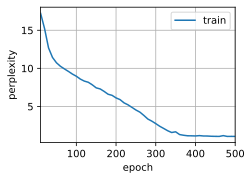

In [5]:
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1
model = d2l.RNNModelScratch(len(vocab), num_hiddens, device, get_params,
                            init_gru_state, gru)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

## Implementação concisa

Em APIs de alto nível,
nós podemos diretamente
instanciar um modelo de GPU.
Isso encapsula todos os detalhes de configuração que tornamos explícitos acima.
O código é significativamente mais rápido, pois usa operadores compilados em vez de Python para muitos detalhes que explicamos antes.


perplexity 1.0, 302984.3 tokens/sec on cuda:0


time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


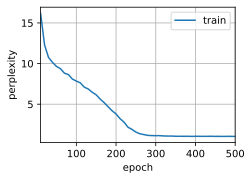

In [6]:
num_inputs = vocab_size
gru_layer = nn.GRU(num_inputs, num_hiddens)
model = d2l.RNNModel(gru_layer, len(vocab))
model = model.to(device)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

## Sumário

* RNNs bloqueados podem capturar melhor as dependências para sequências com grandes distâncias de intervalo de tempo.
* As portas de redefinição ajudam a capturar dependências de curto prazo em sequências.
* Portas de atualização ajudam a capturar dependências de longo prazo em sequências.
* GRUs contêm RNNs básicos como seu caso extremo sempre que a porta de reinicialização é ativada. Eles também podem pular subseqüências ativando a porta de atualização.

## Exercícios

1. Suponha que queremos apenas usar a entrada na etapa de tempo $t'$ para prever a saída na etapa de tempo $t > t'$. Quais são os melhores valores para as portas de reset e atualização para cada intervalo de tempo?
1. Ajuste os hiperparâmetros e analise sua influência no tempo de execução, perplexidade e sequência de saída.
1. Compare o tempo de execução, a perplexidade e as strings de saída para as implementações `rnn.RNN` e `rnn.GRU` entre si.
1. O que acontece se você implementar apenas partes de uma GRU, por exemplo, com apenas uma porta de reinicialização ou apenas uma porta de atualização?


[Discussão](https://discuss.d2l.ai/t/1056)


<!--stackedit_data:
eyJoaXN0b3J5IjpbLTIxNDg3MDc3OCwtNTg1NzE4MDIwLC0yMD
A3OTk3MDcsODQ1NDQ2ODExLC03NzUxODQzMjBdfQ==
-->
